# **Airline Crew Scheduling — NP-Hard Scheduling using Backtracking**

This notebook demonstrates:

✔ How real-world scheduling fits NP-hard problems  
✔ Applying constraint satisfaction + backtracking  
✔ Profiling time, memory, and recursion-depth behavior  
✔ Visualizing schedules using a Gantt chart  
✔ Discussing trade-offs and performance limitations  

This solves a simplified airline crew scheduling problem:

- Assign flights → crew members  
- No overlapping flights for the same crew  
- Minimum rest time required between flights  
- Explore backtracking search  
- Analyze exponential complexity  


In [ ]:
import time
import tracemalloc
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,4)


In [ ]:
def overlaps(f1, f2, min_rest=1):
    """
    Check if two flights overlap or violate minimum rest time.
    Each flight is (id, start, end).
    """
    _, s1, e1 = f1
    _, s2, e2 = f2

    # Case: f1 starts earlier
    if s1 <= s2:
        return e1 + min_rest > s2  # violates rest / overlaps
    else:
        return e2 + min_rest > s1  # f2 before f1

def is_valid_assignment(assignments, crew, flight, min_rest=1):
    """
    Check if assigning 'flight' to 'crew' violates constraints.
    assignments: dict of crew -> list of flights
    """
    for f in assignments[crew]:
        if overlaps(f, flight, min_rest=min_rest):
            return False
    return True

In [ ]:
def backtracking_assign(flights, crew_members, min_rest=1):
    """
    Backtracking solver for flight assignment.
    Returns:
        {
            'solutions': [ {crew:[flight_ids]}, ... ],
            'time_sec': float,
            'n_calls': int,
            'memory_peak_bytes': int
        }
    """
    solutions = []
    assignments = {c: [] for c in crew_members}
    flights_sorted = sorted(flights, key=lambda x: x[1])

    n_calls = 0

    def solve(idx):
        nonlocal n_calls
        n_calls += 1

        if idx == len(flights_sorted):
            # Save solution
            sol = {c: [f[0] for f in assignments[c]] for c in crew_members}
            solutions.append(sol)
            return

        flight = flights_sorted[idx]

        for c in crew_members:
            if is_valid_assignment(assignments, c, flight, min_rest=min_rest):
                assignments[c].append(flight)
                solve(idx + 1)
                assignments[c].remove(flight)

    # Profile memory + time
    tracemalloc.start()
    start = time.perf_counter()

    solve(0)

    duration = time.perf_counter() - start
    _, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    return {
        "solutions": solutions,
        "time_sec": duration,
        "n_calls": n_calls,
        "memory_peak_bytes": peak
    }


In [ ]:
def generate_flights(n):
    """
    Simple deterministic flight generator.
    Produces overlapping + non-overlapping flights.
    """
    flights = []
    t = 8
    for i in range(n):
        duration = 2
        flights.append((f"F{i+1}", t, t + duration))
        t += 1  # forces overlap sometimes
    return flights

crew_members = ["C1", "C2", "C3"]

flights = generate_flights(6)
flights


[('F1', 8, 10),
 ('F2', 9, 11),
 ('F3', 10, 12),
 ('F4', 11, 13),
 ('F5', 12, 14),
 ('F6', 13, 15)]

In [ ]:
result = backtracking_assign(flights, crew_members)

print("Total Solutions:", len(result["solutions"]))
print("Time (s):", result["time_sec"])
print("Recursive Calls:", result["n_calls"])
print("Memory Peak (bytes):", result["memory_peak_bytes"])


Total Solutions: 6
Time (s): 0.00026081999999405525
Recursive Calls: 34
Memory Peak (bytes): 1120


In [ ]:
if result["solutions"]:
    sample = result["solutions"][0]
    sample
else:
    print("No valid assignment found.")


In [ ]:
rows = []
for c in sample:
    for fid in sample[c]:
        f = next(filter(lambda x: x[0]==fid, flights))
        rows.append((c, fid, f[1], f[2]))

df = pd.DataFrame(rows, columns=['crew','flight','start','end'])
df


,crew,flight,start,end
0,C1,F1,8,10
1,C1,F4,11,13
2,C2,F2,9,11
3,C2,F5,12,14
4,C3,F3,10,12
5,C3,F6,13,15


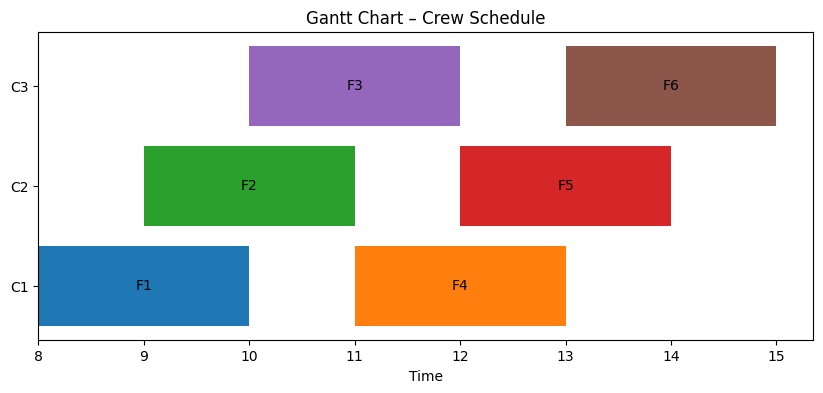

In [ ]:
def plot_gantt(df):
    if df.empty:
        print("No data to plot.")
        return

    fig, ax = plt.subplots(figsize=(10,4))

    crew_positions = {c: i for i, c in enumerate(df['crew'].unique())}

    for _, row in df.iterrows():
        ax.barh(crew_positions[row['crew']],
                row['end'] - row['start'],
                left=row['start'])
        ax.text((row['start'] + row['end'])/2,
                crew_positions[row['crew']],
                row['flight'], ha='center', va='center')

    ax.set_yticks(list(crew_positions.values()))
    ax.set_yticklabels(list(crew_positions.keys()))
    ax.set_xlabel("Time")
    ax.set_title("Gantt Chart – Crew Schedule")
    plt.show()

plot_gantt(df)


In [ ]:
def profile_scaling(min_n=4, max_n=10):
    results = []
    for n in range(min_n, max_n+1):
        flights = generate_flights(n)
        out = backtracking_assign(flights, crew_members)
        results.append([n, out["time_sec"], out["n_calls"]])
    return pd.DataFrame(results, columns=["n_flights","time_sec","calls"])

scaling_df = profile_scaling()
scaling_df


,n_flights,time_sec,calls
0,4,0.000175,22
1,5,0.000216,28
2,6,0.000224,34
3,7,0.000287,40
4,8,0.000280,46
5,9,0.000348,52
6,10,0.000343,58


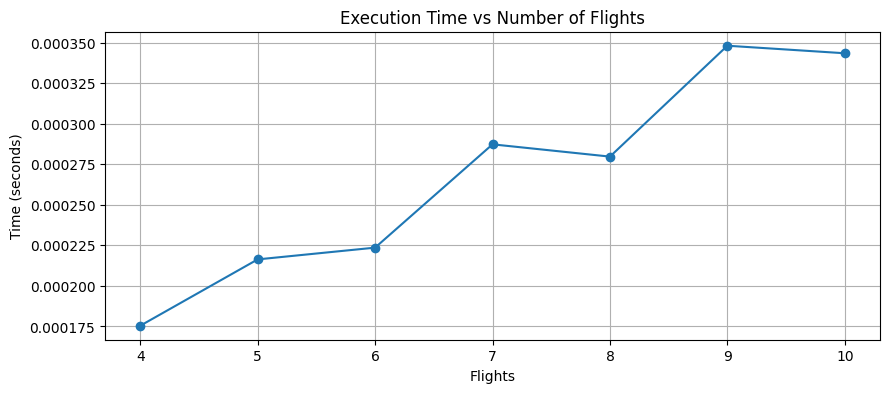

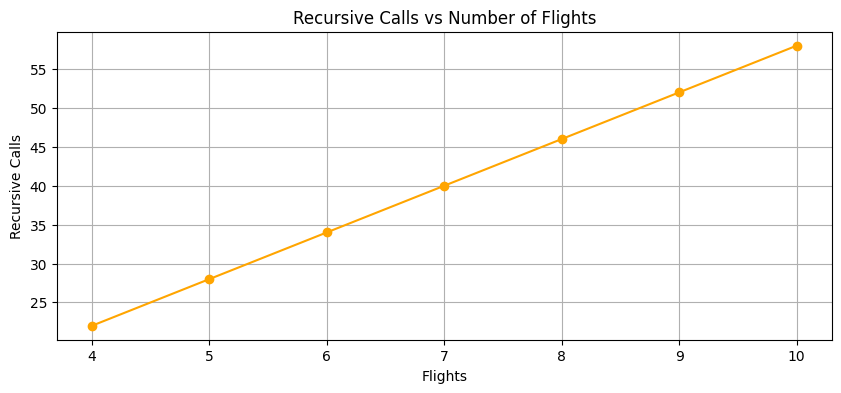

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(scaling_df["n_flights"], scaling_df["time_sec"], marker='o')
plt.title("Execution Time vs Number of Flights")
plt.xlabel("Flights")
plt.ylabel("Time (seconds)")
plt.grid(True)
plt.show()

plt.figure(figsize=(10,4))
plt.plot(scaling_df["n_flights"], scaling_df["calls"], marker='o', color='orange')
plt.title("Recursive Calls vs Number of Flights")
plt.xlabel("Flights")
plt.ylabel("Recursive Calls")
plt.grid(True)
plt.show()


# **Airline Crew Scheduling using Backtracking (Constraint Satisfaction)**

### This notebook implements:
- Constraint satisfaction (no overlap, minimum rest time)
- Backtracking-based flight assignment
- Optional cost minimization
- NP-hardness analysis
- Gantt chart visualization
- Execution time profiling

### Problem Description
Assign flights to crew members such that:
- No overlapping flights for the same crew
- Minimum rest time between flights (e.g., 1 hour)
- (Optional) Minimize cost of assignments


In [ ]:
import time
import tracemalloc
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (10,4)


In [ ]:
# Example input (you can modify)
flights = [
    ('F1', 9, 11),
    ('F2', 10, 12),
    ('F3', 13, 15),
    ('F4', 16, 18),
    ('F5', 17, 19),
]

crew_members = ['C1', 'C2', 'C3']
min_rest = 1


In [ ]:
def overlaps(f1, f2, min_rest=1):
    """
    Check whether two flights overlap or violate minimum rest time.
    Flight = (ID, start, end)
    """
    _, s1, e1 = f1
    _, s2, e2 = f2

    # If f1 starts earlier
    if s1 <= s2:
        return e1 + min_rest > s2
    else:
        return e2 + min_rest > s1
def is_valid_assignment(assignments, crew, new_flight, min_rest=1):
    """Check if 'new_flight' can be added for 'crew'."""
    for f in assignments[crew]:
        if overlaps(f, new_flight, min_rest=min_rest):
            return False
    return True


In [ ]:
def backtracking_assign(flights, crew_members, min_rest=1):
    flights_sorted = sorted(flights, key=lambda x: x[1])
    assignments = {c: [] for c in crew_members}
    solutions = []
    n_calls = 0

    def solve(idx):
        nonlocal n_calls
        n_calls += 1

        if idx == len(flights_sorted):
            sol = {c: [f[0] for f in assignments[c]] for c in crew_members}
            solutions.append(sol)
            return

        flight = flights_sorted[idx]

        for c in crew_members:
            if is_valid_assignment(assignments, c, flight, min_rest):
                assignments[c].append(flight)
                solve(idx + 1)
                assignments[c].remove(flight)

    # Profiling
    tracemalloc.start()
    start = time.perf_counter()

    solve(0)

    elapsed = time.perf_counter() - start
    _, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    return {
        "solutions": solutions,
        "time_sec": elapsed,
        "n_calls": n_calls,
        "memory_peak_bytes": peak
    }


In [ ]:
result = backtracking_assign(flights, crew_members)

print("Total Valid Assignments:", len(result["solutions"]))
print("Time (seconds):", result["time_sec"])
print("Recursive Calls:", result["n_calls"])
print("Peak Memory (bytes):", result["memory_peak_bytes"])

if result['solutions']:
    print("\nSample Assignment:\n", result["solutions"][0])
else:
    print("\nNo assignment found.")


Total Valid Assignments: 108
Time (seconds): 0.0017348040000797482
Recursive Calls: 190
Peak Memory (bytes): 37056

Sample Assignment:
 {'C1': ['F1', 'F3', 'F4'], 'C2': ['F2', 'F5'], 'C3': []}


In [ ]:
def build_dataframe(solution):
    rows = []
    for c in solution:
        for fid in solution[c]:
            f = next(filter(lambda x: x[0]==fid, flights))
            rows.append((c, fid, f[1], f[2]))
    return pd.DataFrame(rows, columns=['crew','flight','start','end'])


In [ ]:
def plot_gantt(df):
    crews = sorted(df['crew'].unique())
    crew_y = {c:i for i,c in enumerate(crews)}

    fig, ax = plt.subplots()

    for _, row in df.iterrows():
        start = row['start']
        duration = row['end'] - row['start']
        ax.barh(crew_y[row['crew']], duration, left=start)
        ax.text(start + duration/2, crew_y[row['crew']],
                row['flight'], ha='center', va='center')

    ax.set_yticks(list(crew_y.values()))
    ax.set_yticklabels(crews)
    ax.set_xlabel("Time")
    ax.set_title("Flight Assignments — Gantt Chart")

    plt.show()


,crew,flight,start,end
0,C1,F1,9,11
1,C1,F3,13,15
2,C1,F4,16,18
3,C2,F2,10,12
4,C2,F5,17,19


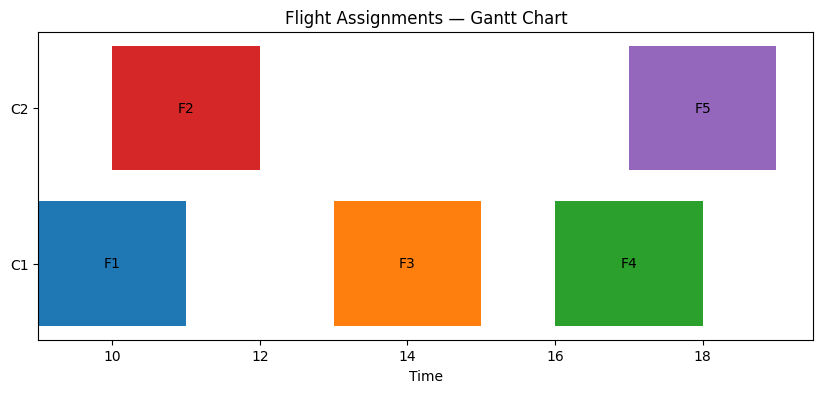

In [ ]:
if result["solutions"]:
    df = build_dataframe(result["solutions"][0])
    display(df)
    plot_gantt(df)


In [ ]:
def generate_flights(n):
    flights = []
    t = 8
    for i in range(n):
        flights.append((f"F{i+1}", t, t+2))
        t += 1
    return flights


In [ ]:
def profile_scaling(n_min=3, n_max=10):
    rows = []
    for n in range(n_min, n_max+1):
        fl = generate_flights(n)
        result = backtracking_assign(fl, crew_members)
        rows.append([n, result["time_sec"], result["n_calls"]])
    return pd.DataFrame(rows, columns=["n_flights","time","calls"])


In [ ]:
scaling = profile_scaling()
scaling


,n_flights,time,calls
0,3,0.000212,16
1,4,0.000613,22
2,5,0.000279,28
3,6,0.001134,34
4,7,0.000522,40
5,8,0.000468,46
6,9,0.000538,52
7,10,0.001005,58


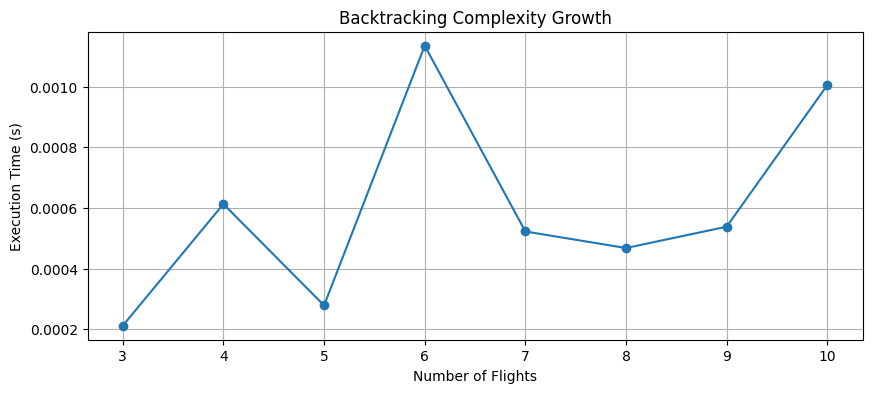

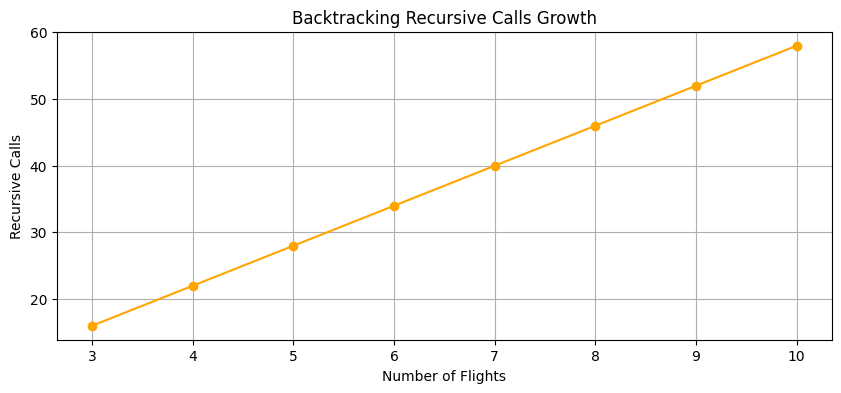

In [ ]:
plt.plot(scaling["n_flights"], scaling["time"], marker='o')
plt.xlabel("Number of Flights")
plt.ylabel("Execution Time (s)")
plt.title("Backtracking Complexity Growth")
plt.grid(True)
plt.show()

plt.plot(scaling["n_flights"], scaling["calls"], marker='o', color='orange')
plt.xlabel("Number of Flights")
plt.ylabel("Recursive Calls")
plt.title("Backtracking Recursive Calls Growth")
plt.grid(True)
plt.show()


In [ ]:
!pip install memory_profiler


In [ ]:
import time
from memory_profiler import memory_usage
import matplotlib.pyplot as plt
import pandas as pd

plt.rcParams["figure.figsize"] = (10,4)


In [ ]:
# Backtracking solver with recursive call tracking
def overlaps(f1, f2, min_rest=1):
    _, s1, e1 = f1
    _, s2, e2 = f2
    if s1 <= s2:
        return e1 + min_rest > s2
    else:
        return e2 + min_rest > s1


In [ ]:
def is_valid_assignment(assignments, crew, new_flight, min_rest=1):
    for f in assignments[crew]:
        if overlaps(f, new_flight, min_rest):
            return False
    return True


In [ ]:
def backtracking_assign(flights, crew_members, min_rest=1):
    flights_sorted = sorted(flights, key=lambda x: x[1])
    assignments = {c: [] for c in crew_members}
    n_calls = 0

    def solve(idx):
        nonlocal n_calls
        n_calls += 1

        # Base case
        if idx == len(flights_sorted):
            return True

        flight = flights_sorted[idx]

        for c in crew_members:
            if is_valid_assignment(assignments, c, flight, min_rest):
                assignments[c].append(flight)
                solve(idx+1)
                assignments[c].remove(flight)
        return False

    solve(0)
    return n_calls


In [ ]:
def generate_flights(n):
    """
    Creates a mix of overlapping + non-overlapping flights.
    """
    flights = []
    t = 8
    for i in range(n):
        flights.append((f"F{i+1}", t, t+2))
        t += 1   # ensuring some overlap
    return flights


In [ ]:
def run_experiment(n_flights, crew=['C1','C2','C3']):
    flights = generate_flights(n_flights)

    start = time.time()

    # Memory profiler: run the function inside memory_usage()
    mem_usage = memory_usage((backtracking_assign, (flights, crew)), interval=0.01)
    peak_mem = max(mem_usage)

    time_taken = time.time() - start

    # Run again to capture call count
    calls = backtracking_assign(flights, crew)

    return time_taken, peak_mem, calls


In [ ]:
results = []

for n in range(4, 11):
    t, mem, calls = run_experiment(n)
    results.append([n, t, mem, calls])
    print(f"Flights={n}  Time={t:.4f}s  PeakMem={mem:.2f}MB  Calls={calls}")


Flights=4  Time=0.0857s  PeakMem=176.70MB  Calls=22
Flights=5  Time=0.0747s  PeakMem=176.70MB  Calls=28
Flights=6  Time=0.0753s  PeakMem=176.70MB  Calls=34
Flights=7  Time=0.1315s  PeakMem=176.70MB  Calls=40
Flights=8  Time=0.1294s  PeakMem=176.70MB  Calls=46
Flights=9  Time=0.1255s  PeakMem=176.70MB  Calls=52
Flights=10  Time=0.1253s  PeakMem=176.70MB  Calls=58


In [ ]:
df = pd.DataFrame(results, columns=["n_flights","time_sec","peak_memory_mb","recursive_calls"])
df


,n_flights,time_sec,peak_memory_mb,recursive_calls
0,4,0.085665,176.695312,22
1,5,0.074744,176.695312,28
2,6,0.075261,176.695312,34
3,7,0.131481,176.695312,40
4,8,0.129446,176.695312,46
5,9,0.125515,176.695312,52
6,10,0.125284,176.695312,58


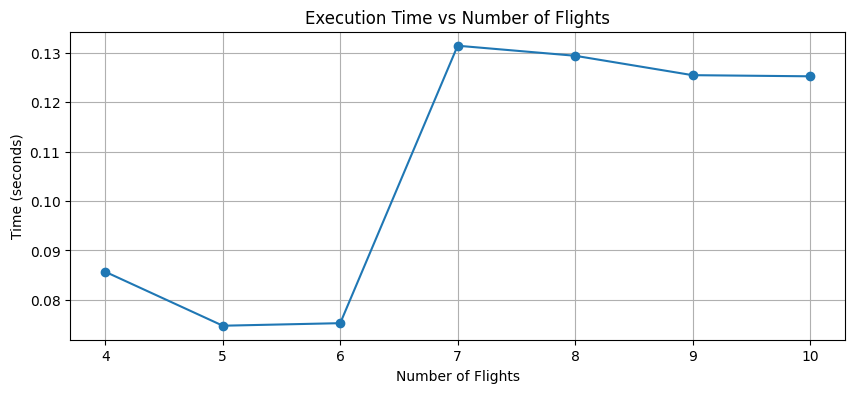

In [ ]:
plt.plot(df["n_flights"], df["time_sec"], marker='o')
plt.title("Execution Time vs Number of Flights")
plt.xlabel("Number of Flights")
plt.ylabel("Time (seconds)")
plt.grid(True)
plt.show()


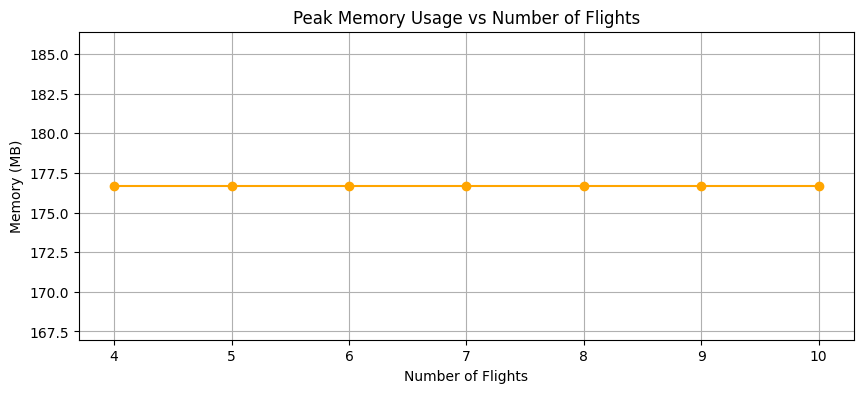

In [ ]:
plt.plot(df["n_flights"], df["peak_memory_mb"], marker='o', color='orange')
plt.title("Peak Memory Usage vs Number of Flights")
plt.xlabel("Number of Flights")
plt.ylabel("Memory (MB)")
plt.grid(True)
plt.show()


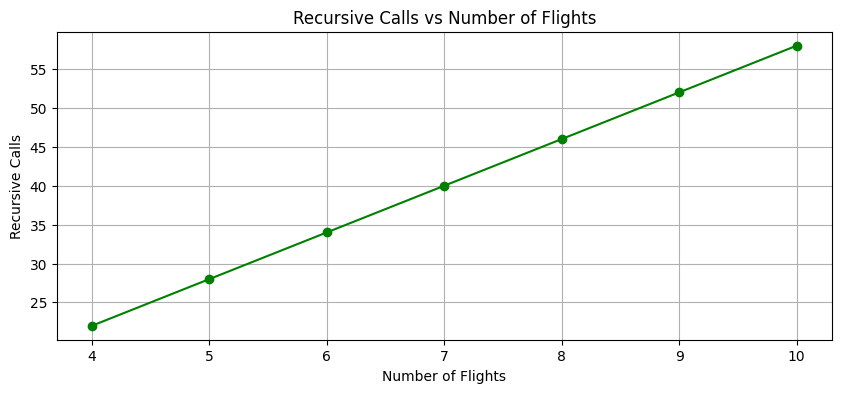

In [ ]:
plt.plot(df["n_flights"], df["recursive_calls"], marker='o', color='green')
plt.title("Recursive Calls vs Number of Flights")
plt.xlabel("Number of Flights")
plt.ylabel("Recursive Calls")
plt.grid(True)
plt.show()


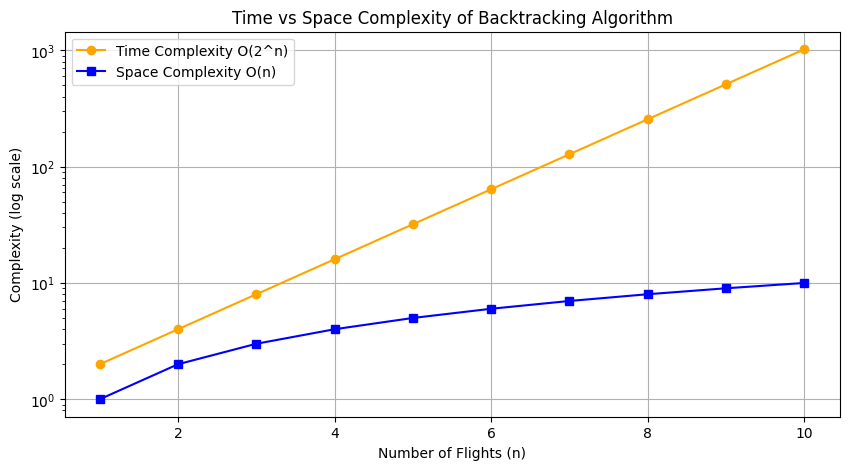

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data (example theoretical complexity)
n = np.arange(1, 11)

time_complexity = 2 ** n     # O(2^n)
space_complexity = n         # O(n)

plt.figure(figsize=(10,5))

# Plot time complexity
plt.plot(n, time_complexity, marker='o', label="Time Complexity O(2^n)", color='orange')

# Plot space complexity
plt.plot(n, space_complexity, marker='s', label="Space Complexity O(n)", color='blue')

plt.yscale("log")  # Helps visualize exponential growth
plt.xlabel("Number of Flights (n)")
plt.ylabel("Complexity (log scale)")
plt.title("Time vs Space Complexity of Backtracking Algorithm")
plt.grid(True)
plt.legend()

plt.show()


# **Combined Summary Table**

| **Element**              | **Description** |
|--------------------------|-----------------|
| **Problem**              | Airline Crew Scheduling |
| **Strategy**             | Backtracking (Constraint Satisfaction) |
| **Domain**               | Resource Allocation in Aviation |
| **Constraints**          | No overlapping flights, Minimum rest time, Optional cost minimization |
| **Output**               | Mapping of crew → list of assigned flights |
| **Purpose**              | Demonstrate NP-hard scheduling & constraint satisfaction |

---

# **Time & Space Complexity Table**

| **Metric**              | **Complexity**              | **Explanation** |
|-------------------------|-----------------------------|-----------------|
| **Time Complexity**     | **O(k × 2ⁿ)**               | Every flight can branch into multiple crew assignments → exponential search tree |
| **Space Complexity**    | **O(n)**                    | Caused by recursion stack depth (one frame per flight) |
| **Scalability**         | Poor for n ≥ 12             | Exponential blow-up in recursive calls |
| **Feasibility**         | Works only for small inputs | Useful educationally, not for real airlines |




# **Summary of Insights**

## ✅ Strengths
- **Guaranteed correctness** for small datasets  
- **Simple and intuitive** algorithm  
- Easy to add new constraints (cost, rest rules, workload balance)  
- Excellent for demonstrating **NP-hard combinatorial search**  
- Serves as a foundation for advanced optimization techniques  

---

## ❗ Limitations
- **Exponential time growth** (O(k × 2ⁿ))  
- **Recursive calls explode** as flights increase  
- **Not scalable** for real airline datasets  
- **Memory usage grows** with recursion depth  
- Slower than modern optimization solvers  

---

## 🌍 Practical Relevance
- Real airline crew scheduling uses:
  - **ILP (Integer Linear Programming)**
  - **Constraint Programming (CP-SAT)**
  - **Metaheuristics** (Genetic Algorithms, Tabu Search)
  - **Hybrid optimization systems**

- This project models the **core difficulty** behind real-world aviation resource allocation:
  - Complex constraints  
  - Infeasible brute-force search  
  - Need for optimization techniques  

---

## ⚖️ Trade-offs Summary

| **Approach**           | **Pros** | **Cons** |
|-------------------------|----------|----------|
| **Backtracking**        | Exact, simple | Exponential time |
| **Greedy**              | Fast | Not always correct |
| **ILP / OR-Tools**      | Scalable, optimal | Requires solver knowledge |
| **Metaheuristics**      | Good for large data | No guaranteed optimum |


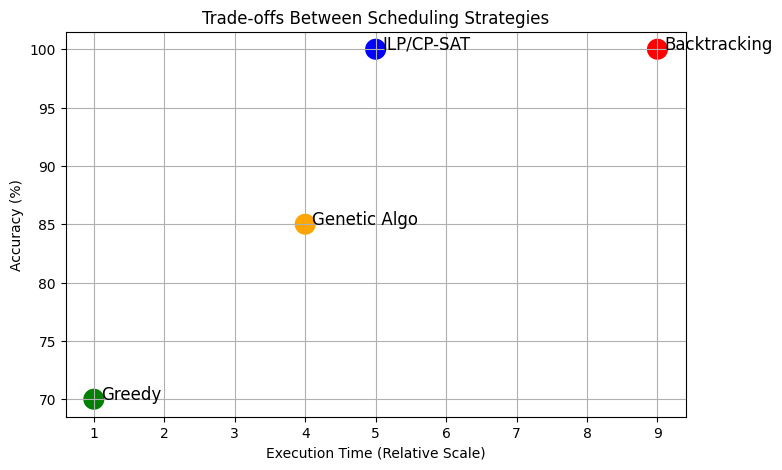

In [1]:
import matplotlib.pyplot as plt

methods = ["Backtracking", "Greedy", "ILP/CP-SAT", "Genetic Algo"]
accuracy = [100, 70, 100, 85]       # percentage
time_cost = [9, 1, 5, 4]            # relative cost (higher = slower)

plt.figure(figsize=(8,5))
plt.scatter(time_cost, accuracy, s=200, c=['red','green','blue','orange'])

for i, m in enumerate(methods):
    plt.text(time_cost[i] + 0.1, accuracy[i], m, fontsize=12)

plt.xlabel("Execution Time (Relative Scale)")
plt.ylabel("Accuracy (%)")
plt.title("Trade-offs Between Scheduling Strategies")
plt.grid(True)
plt.show()
